In [44]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

Optimized Step Times: [1. 1. 1. 1.]
Best Fidelity: 0.8839619546615924


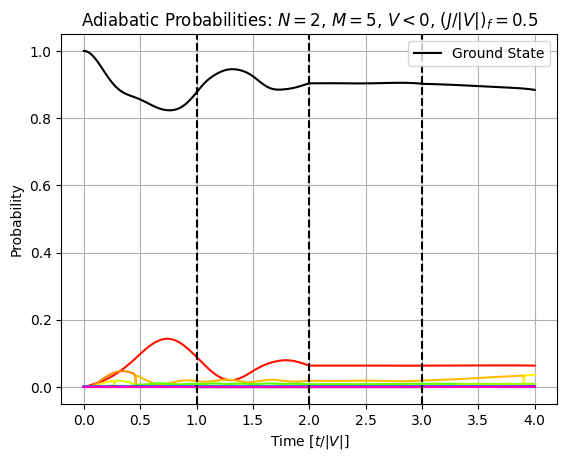

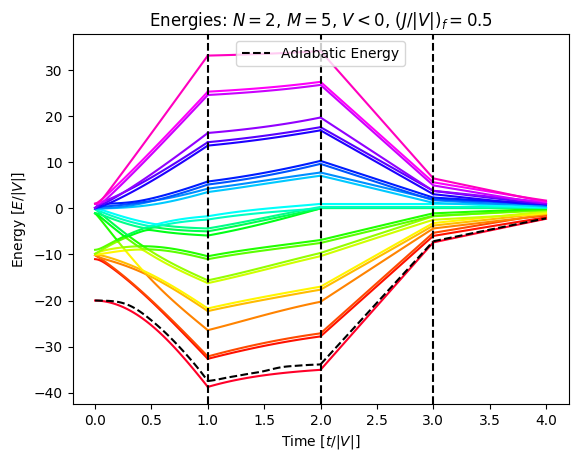

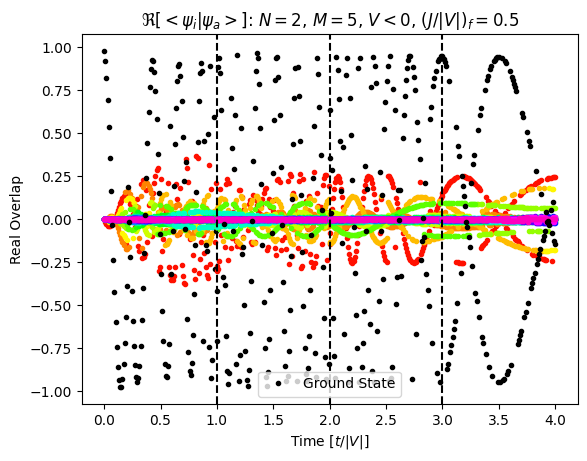

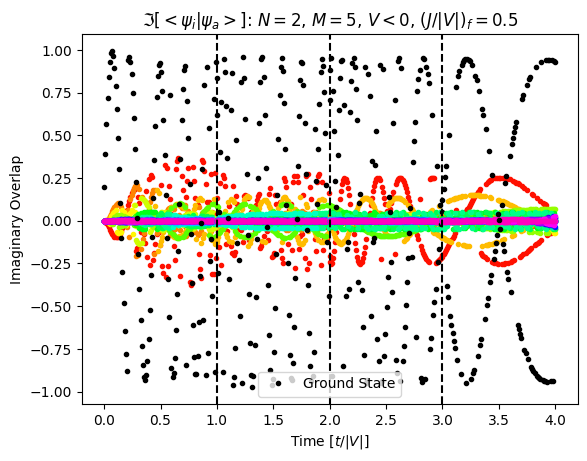

In [52]:
import itertools
from scipy.optimize import minimize

def adiabatic_evolution(N, M, V, dt, mu_V_ratio_steps, J_V_ratio_steps, step_times):
    num_steps = len(step_times)
    results = []
    initial_state = None
    accumulated_time = 0

    for i in range(num_steps):
        total_time = step_times[i]
        total_steps = int(total_time / dt)
        times = np.linspace(0, total_time, total_steps)
        mu_V_ratio_routine = np.linspace(mu_V_ratio_steps[i][0], mu_V_ratio_steps[i][-1], total_steps)
        J_V_ratio_routine = np.linspace(J_V_ratio_steps[i][0], J_V_ratio_steps[i][-1], total_steps)

        adiabatic_energies, adiabatic_wavefunctions, adiabatic_probabilities, adiabatic_overlaps, true_energies = \
            simulate_adiabatic_evolution(N, M, V, mu_V_ratio_routine, J_V_ratio_routine, times, dt=dt, initial_state=initial_state)
        
        results.append({
            "times": times + accumulated_time,
            "adiabatic_probabilities": adiabatic_probabilities,
            "adiabatic_wavefunctions": adiabatic_wavefunctions,
            "adiabatic_energies": adiabatic_energies,
            "adiabatic_overlaps": adiabatic_overlaps,
            "true_energies": true_energies
        })
        
        initial_state = adiabatic_wavefunctions[-1]
        accumulated_time += total_time

    ground_state_probability = adiabatic_probabilities[-1, 0]
    return results, ground_state_probability

def optimize_time_allocation(N, M, V, dt, mu_V_ratio_steps, J_V_ratio_steps, total_time):

    def fidelity_from_step_times(step_times):
        results, fidelity = adiabatic_evolution(N, M, V, dt, mu_V_ratio_steps, J_V_ratio_steps, step_times)
        return -fidelity  # Negative because we minimize, but want to maximize fidelity

    # Initial guess for step times: evenly distributed total time
    initial_step_times = [total_time / len(mu_V_ratio_steps) + np.random.uniform(-0.25,0.25) ] * len(mu_V_ratio_steps) 

    # Constraint: sum of step times must equal total_time
    constraints = ({
        'type': 'eq',
        'fun': lambda step_times: np.sum(step_times) - total_time
    })

    # Bounds: each step time must be non-negative
    bounds = [(0, total_time) for _ in initial_step_times]

    # Run optimization
    result = minimize(fidelity_from_step_times, initial_step_times, bounds=bounds, constraints=constraints, method='SLSQP')

    optimized_step_times = result.x
    best_fidelity = -result.fun  # Since we minimized the negative fidelity

    # Run one more time with optimized step times to get the best results
    best_results, _ = adiabatic_evolution(N, M, V, dt, mu_V_ratio_steps, J_V_ratio_steps, optimized_step_times)

    return optimized_step_times, best_fidelity, best_results

# Define the parameters
N = 2  # Example values, adjust as needed
M = 5  # Example values, adjust as needed
V = -1.0  # Example values, adjust as needed
dt = 0.01  # Example values, adjust as needed
total_time = 4  # Specify your total time here

mu_V_ratio_steps = [
    np.array([10, 10]),  # Step 1
    np.array([10, 0]),   # Step 2
    np.array([0, 0]),    # Step 3
    np.array([0, 0])     # Step 4
]
J_V_ratio_steps = [
    np.array([0.1, 10]), # Step 1
    np.array([10, 10]),  # Step 2
    np.array([10, 2]),   # Step 3
    np.array([2, 0.5])   # Step 4
]

# Run optimization
optimized_step_times, best_fidelity, best_results = optimize_time_allocation(N, M, V, dt, mu_V_ratio_steps, J_V_ratio_steps, total_time)

# Plot the best result
plot_multistep_adiabatic_evolution_results(best_results, N, M, J_V_ratio_steps, optimized_step_times)

print("Optimized Step Times:", optimized_step_times)
print("Best Fidelity:", best_fidelity)
